In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from PIL import Image
import requests
import torch
import matplotlib.pyplot as plt
import numpy as np

import torch
import requests
from tqdm import tqdm
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline
import torchvision.transforms as T
from typing import Union, List, Optional, Callable
import csv
import datetime
to_pil = T.ToPILImage()

from utils import *

import open_clip
from utils_text import *
from torchvision import transforms
import argparse
from ddd import *


/local/java/python-ml/22-12-21-python3.9/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.2.3) or chardet (None)/charset_normalizer (2.1.1) doesn't match a supported version!
  warnings.warn(
2024-11-07 22:54:14.432214: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-07 22:54:14.509434: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-07 22:54:15.247489: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Coul

In [2]:
args_dict = {
    "prompt_len": 16,
    "iter": 3000,
    "lr": 0.1,
    "weight_decay": 0.1,
    "prompt_bs": 1,
    "loss_weight": 1.0,
    "print_step": 100,
    "batch_size": 1,
    "clip_model": "ViT-H-14",
    "clip_pretrain": "laion2b_s32b_b79k"
}

def dict_to_args_parser(input_dict):
    parser = argparse.ArgumentParser()

    for key, value in input_dict.items():
        parser.add_argument(f'--{key}', default=value, type=type(value))

    return parser.parse_args([])

args = dict_to_args_parser(args_dict)

In [3]:
from ddd import *

# load img from img/{testimg_filename}.png, masked img is also required img/{testimg_filename}_masked.png
testimg_filename = "009"

model_version = "runwayml/stable-diffusion-inpainting"

pipe_inpaint = StableDiffusionInpaintPipeline.from_pretrained(
    model_version, 
    variant="fp16",
    torch_dtype=torch.float32,
)

pipe_inpaint = pipe_inpaint.to("cuda")
pipe_inpaint.safety_checker = None

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [4]:
pipe_inpaint.vae.requires_grad_(False)
pipe_inpaint.unet.requires_grad_(False)
device = "cuda"
weight_dtype = torch.float32
image_length = 512

tokenizer = pipe_inpaint.tokenizer
token_embedding = pipe_inpaint.text_encoder.text_model.embeddings.token_embedding

preprocess = transforms.Compose(
    [
        transforms.Resize(512, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(512),
        transforms.ToTensor(),
    ]
)

In [5]:
pipe_inpaint.to(torch_dtype=torch.float32)

orig_images = Image.open(f'./images/{testimg_filename}.png').convert('RGB').resize((512,512))
mask_image_orig = Image.open(f'./images/{testimg_filename}_masked.png').convert('RGB').resize((512,512))
mask_image = ImageOps.invert(mask_image_orig).resize((512,512))
# mask_image = ImageOps.invert(mask_image).resize((512,512))

# mask_image.show()
cur_mask, cur_masked_image, init_image = prepare_mask_and_masked2(orig_images, mask_image, no_mask=False,inverted=True)
inv_cur_mask, _, _ = prepare_mask_and_masked2(orig_images, mask_image, no_mask=False,inverted=False)

cur_mask = cur_mask.to("cuda")
cur_masked_image = cur_masked_image.to("cuda")

with torch.no_grad():
    curr_images = preprocess(orig_images).to(device)
    mask = torch.nn.functional.interpolate(cur_mask, size=(512 // 8, 512 // 8))
    if len(curr_images.shape) ==3:
        curr_images = curr_images.unsqueeze(0)
    elif len(curr_images.shape) ==5:
        curr_images = curr_images.squeeze(0)
    all_latents = pipe_inpaint.vae.encode(curr_images.to(weight_dtype)).latent_dist.sample()
    all_latents = all_latents * 0.18215
    masked_image_latents = pipe_inpaint.vae.encode(cur_masked_image).latent_dist.sample() * 0.18215
    gt_embeddings = get_text_embedding(pipe_inpaint,testimg_filename)
    uncond_embeddings = get_text_embedding(pipe_inpaint,"")


In [6]:
pipe_inpaint.dtype

torch.float32

# Token Projective Embedding Optimization

In [7]:
args.prompt_len = 8
args.opt_iters = 350
args.eval_step = 50
# discrete = True
args.lr = 0.0001

In [8]:
args.lr = 0.001
prompt_embeds, dummy_embeds, dummy_ids = initialize_prompt(tokenizer, token_embedding, args, device)
input_optimizer = torch.optim.AdamW([prompt_embeds], lr=args.lr, weight_decay=args.weight_decay)
input_optim_scheduler = None
best_loss = -999
eval_loss = -99999
best_text = ""
best_embeds = None
for step in range(args.opt_iters):
    if step > args.opt_iters - 10: # Finalize with full continuous update
        args.lr = 0.0001
        projected_embeds, nn_indices = nn_project(prompt_embeds, token_embedding)
        tmp_embeds = copy.deepcopy(prompt_embeds)
        tmp_embeds.data = projected_embeds.data
        tmp_embeds.requires_grad = True
    else:
        tmp_embeds = copy.deepcopy(prompt_embeds)
        tmp_embeds.data = prompt_embeds.data
        tmp_embeds.requires_grad = True

    padded_embeds = copy.deepcopy(dummy_embeds)
    padded_embeds[:, 1:args.prompt_len+1] = tmp_embeds
    padded_embeds = padded_embeds.repeat(args.batch_size, 1, 1)
    padded_dummy_ids = dummy_ids.repeat(args.batch_size, 1)

    if args.batch_size is None:
        latents = all_latents
    else:
        perm = torch.randperm(len(all_latents))
        idx = perm[:args.batch_size]
        latents = all_latents[idx]

    noise = torch.randn_like(latents)
    bsz = latents.shape[0]
    timesteps = torch.randint(0, 1000, (bsz,), device=latents.device)
    timesteps = timesteps.long()

    noisy_latents = pipe_inpaint.scheduler.add_noise(latents, noise, timesteps)

    if pipe_inpaint.scheduler.config.prediction_type == "epsilon":
        target = noise
    elif pipe_inpaint.scheduler.config.prediction_type == "v_prediction":
        target = pipe_inpaint.scheduler.get_velocity(latents, noise, timesteps)
    else:
        raise ValueError(f"Unknown prediction type {pipe_inpaint.scheduler.config.prediction_type}")

    text_embeddings = get_text_embedding_with_embeddings(pipe_inpaint,padded_dummy_ids, padded_embeds)

    input_latent = torch.cat([noisy_latents, mask, masked_image_latents],dim=1)
#     print(timesteps.shape, text_embeddings.shape)
    model_pred = pipe_inpaint.unet(input_latent, timesteps, encoder_hidden_states=text_embeddings).sample
    inverted_mask = mask

    target = target * inverted_mask
    model_pred = model_pred * inverted_mask
    loss = torch.nn.functional.mse_loss(model_pred.float(), target.float(), reduction="mean")
    prompt_embeds.grad, = torch.autograd.grad(loss, [tmp_embeds])
    input_optimizer.step()
    input_optimizer.zero_grad()

    curr_lr = input_optimizer.param_groups[0]["lr"]

In [9]:
input_text_embedding = text_embeddings.detach()
input_text_embeddings = torch.cat([input_text_embedding]*2)

In [10]:
pipe_inpaint.to(torch_dtype=torch.float16)

# for testimg_filename in test_file_list:
init_image = Image.open(f'./images/{testimg_filename}.png').convert('RGB').resize((512,512))
mask_image = Image.open(f'./images/{testimg_filename}_masked.png').convert('RGB')
mask_image = ImageOps.invert(mask_image).resize((512,512))


target_prompt = ""

prompt = ""
SEED = 786349
torch.manual_seed(SEED)

cur_mask, cur_masked_image = prepare_mask_and_masked(init_image, mask_image)

cur_mask = cur_mask.half().to("cuda")
cur_masked_image = cur_masked_image.half().to("cuda")

strength = 0.7
guidance_scale = 7.5
num_inference_steps = 4

text_embeddings = text_embedding(pipe_inpaint, target_prompt)


latents_shape = (1 , pipe_inpaint.vae.config.latent_channels, 512 // 8, 512 // 8)
noise = torch.randn(latents_shape, device=pipe_inpaint.device, dtype=text_embeddings.dtype)

image_latent = pil_to_latent(pipe_inpaint,init_image)



# Monte Carlo sampling (Semantic Centroid Construction)

In [11]:
from functools import partial
from collections import OrderedDict

prompt = ""
SEED = 786349

t_schedule = [720]
t_schedule_bound = 10
n_samples = 50
loss_depth = [256, 64]

torch.manual_seed(SEED)

cur_mask, cur_masked_image = prepare_mask_and_masked(init_image, mask_image)

cur_mask = cur_mask.to("cuda")
cur_masked_image = cur_masked_image.to("cuda")

val_loss_criteria = 'MSE'
attn_controller = AttnController(post = False, mask = cur_mask, criteria=val_loss_criteria, target_depth = loss_depth)
module_count = 0
modes = ['','up','down']
mode = 0
# to collect only up or down attns, please deactivate the annotation of 'if' statement below
for n, m in pipe_inpaint.unet.named_modules():
    # if (n.endswith('attn2') and (modes[mode] in n)) or (n.endswith('attn1') and (modes[mode] in n)): #and "down" in n:
    if (n.endswith('attn1') and (modes[mode] in n)): #and "down" in n:
        m.set_processor(MyCrossAttnProcessor(attn_controller, n))
        module_count += 1


sp_prompt = None

for_mean = []
for j in range(n_samples):
    with torch.no_grad():
        mask = cur_mask
        masked_image = cur_masked_image
        random_t = get_random_t(t_schedule, t_schedule_bound)
        uncond_emb = input_text_embeddings
        num_channels_latents = pipe_inpaint.vae.config.latent_channels
        latents_shape = (1 , num_channels_latents, 512 // 8, 512 // 8)
        latents = torch.randn(latents_shape, device=pipe_inpaint.device, dtype=uncond_emb.dtype)

        mask = torch.nn.functional.interpolate(mask, size=(512 // 8, 512 // 8))
        mask = torch.cat([mask] * 2)
        masked_image.dtype
        masked_image_latents = pipe_inpaint.vae.encode(masked_image).latent_dist.sample()
        masked_image_latents = 0.18215 * masked_image_latents
        masked_image_latents = torch.cat([masked_image_latents]*2)

        pipe_inpaint.scheduler.set_timesteps(num_inference_steps)
        timesteps_tensor = pipe_inpaint.scheduler.timesteps.to(pipe_inpaint.device)
        timesteps_tensor = random_t

        for i, t in enumerate(timesteps_tensor):

            latent_model_input = torch.cat([latents] * 2)
            latent_model_input = torch.cat([latent_model_input, mask, masked_image_latents], dim=1)
            _ = pipe_inpaint.unet(latent_model_input, t, encoder_hidden_states=uncond_emb).sample
        for_mean.append(attn_controller.targets)
        attn_controller.zero_attn_probs()
meaned = []
for feature in range(len(for_mean[0])):
    temp = 0
    for idx in range(n_samples):
        temp += for_mean[idx][feature]
    temp /= n_samples
    meaned.append(temp)

attn_controller.target_hidden = meaned
del for_mean, meaned
text_embeddings = [uncond_emb]

# Semantic Digression

In [12]:
now = datetime.datetime.now()
now = str(now)[:19].replace(" ", "_")
nickname = f"run"
directory = f"{nickname}_{now}"
path = f"figures/{directory}"
img_path = path + "/img"
adv_path = path + "/adv"
os.makedirs(path)
os.makedirs(img_path)
os.makedirs(adv_path)


infer_dict = dict()
infer_dict["prompt"] = load_prompt(f"prompts/{testimg_filename}.txt")[0]
infer_dict["num_inference_steps"] = 20
infer_dict["guidance_scale"] = 7.5
infer_dict["strength"] = 0.8
infer_dict["init_image"] = init_image
infer_dict["mask"] = mask_image
infer_dict["prefix"] = 'inter'
infer_dict["path"] = img_path
infer_dict["inter_print"] = []

iters = 250
grad_reps = 7
loss_mask = True
eps = 12
step_size = 3
pixel_loss = 0
val_loss_criteria = 'MSE'

result, last_image, total_losses= disrupt(cur_mask, cur_masked_image,
                text_embeddings = text_embeddings,
                eps=eps,
                step_size=step_size,
                iters=iters,
                clamp_min = -1,
                clamp_max = 1,
                eta=1,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                grad_reps=grad_reps,
                attn_controller = attn_controller,
                pipe=pipe_inpaint,
                loss_depth=loss_depth,
                loss_mask=loss_mask,
                pixel_loss=pixel_loss,
                t_schedule = t_schedule,
                t_schedule_bound = t_schedule_bound,
                infer_dict = infer_dict,
                infer_unet = pipe_inpaint.unet,
                inter_print = infer_dict["inter_print"]
                )
torch.save(result, f'{adv_path}/adv.pt')

Loss: -4.39375: 100%|██████████| 250/250 [12:05<00:00,  2.90s/it]


# Inference

In [13]:
pipe_inpaint = StableDiffusionInpaintPipeline.from_pretrained(
    model_version,
    variant="fp16",
    torch_dtype=torch.float32,
)
pipe_inpaint = pipe_inpaint.to("cuda")
pipe_inpaint.safety_checker = None

for name, param in pipe_inpaint.unet.named_parameters():
    param.requires_grad = False

directory = f"{nickname}_{now}"
path = f"figures/{directory}"
img_path = path + "/img"
adv_path = path + "/adv"
result = torch.load(f'{adv_path}/adv.pt')[0]
adv_X = (result / 2 + 0.5).clamp(0, 1)
adv_image = to_pil(adv_X).convert("RGB")
adv_image = recover_image(adv_image, init_image, mask_image,background=True)
adv_image.show()

adv_image.save(f'./adversarial/{testimg_filename}_adv.png')

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Error: no DISPLAY environment variable specified
Error: no DISPLAY environment variable specified
xdg-open: no method available for opening '/tmp/dcs-tmp.u2102915/tmpjtc1wrct.PNG'


1007


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

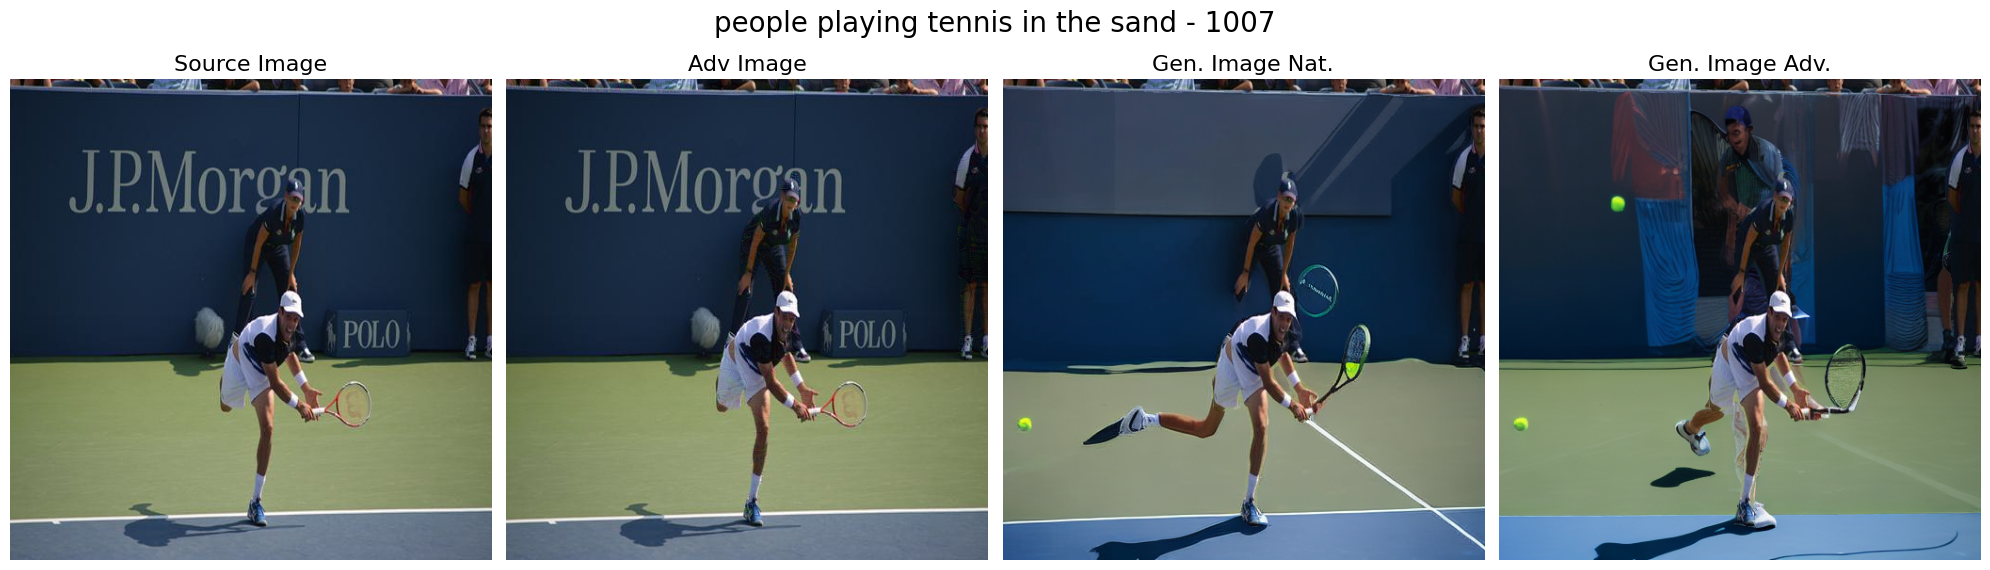

<Figure size 640x480 with 0 Axes>

In [14]:

prompts = load_prompt(f"prompts/{testimg_filename}.txt")

SEED = 1007

with torch.no_grad():
    for prompt in prompts:

        print(SEED)

        torch.manual_seed(SEED)
        strength = 0.8
        guidance_scale = 7.5

        num_inference_steps = 50

        image_nat = pipe_inpaint(prompt=prompt,
                            image=init_image,
                            mask_image=mask_image,
                            eta=1,
                            num_inference_steps=num_inference_steps,
                            guidance_scale=guidance_scale,
                            strength=strength
                            ).images[0]
        image_nat = recover_image(image_nat, init_image, mask_image)

        torch.manual_seed(SEED)
        image_adv = pipe_inpaint(prompt=prompt,
                            image=adv_image,
                            mask_image=mask_image,
                            eta=1,
                            num_inference_steps=num_inference_steps,
                            guidance_scale=guidance_scale,
                            strength=strength
                            ).images[0]

        image_adv = recover_image(image_adv, init_image, mask_image)

        image_adv.save(f'{img_path}/{prompt[:40]}_adv.png')
        fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,6))

        ax[0].imshow(init_image)
        ax[1].imshow(adv_image)
        ax[2].imshow(image_nat)
        ax[3].imshow(image_adv)

        ax[0].set_title('Source Image', fontsize=16)
        ax[1].set_title('Adv Image', fontsize=16)
        ax[2].set_title('Gen. Image Nat.', fontsize=16)
        ax[3].set_title('Gen. Image Adv.', fontsize=16)

        for i in range(4):
            ax[i].grid(False)
            ax[i].axis('off')

        fig.suptitle(f"{prompt} - {SEED}", fontsize=20)
        fig.tight_layout()
        plt.savefig(f'{img_path}/{prompt}.png')
        plt.show()
        
        plt.clf()